# Enrichment


Gene set enrichment analysis allows for the determination of gene sets that are significantly upregulated or downregulated in one population compared to another, providing insights into cellular functions and disease mechanisms.
It is typically performed by aggregating differential expression results across cells, then using statistical methods to determine if specific sets of genes are disproportionately represented among the differentially expressed genes.

Although commonly done for pathways, any gene set can be tested for enrichment.
Pertpy offers rich access to metadata which we can leverage for this purpose.
Here, we'll reproduce [drug2cell](https://github.com/Teichlab/drug2cell) where we'll enrich cells using the [chEMBL database](https://www.ebi.ac.uk/chembl/) which contains bioactive molecules with drug-like properties and their corresponding gene sets.

## Setup

We'll be using the standard processed pbmc3k dataset from scanpy.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pertpy as pt
import scanpy as sc

adata = sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Fetching chEMBL metadata

As a (currently optional!) step we will fetch the chEMBL metadata and examine it:

In [4]:
pt_chembl = pt.md.Drug()

In [5]:
pt_chembl.annotate(adata)

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells', 'compounds'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [6]:
non_empty_compounds = adata.var["compounds"][adata.var["compounds"] != ""]
non_empty_compounds

index
CDA                                CHEMBL3237547|CEDAZURIDINE
HDAC1       CHEMBL343448|ROMIDEPSIN|CHEMBL3545368|PANOBINO...
FAAH                                  CHEMBL112|ACETAMINOPHEN
PKN2        CHEMBL1421|DASATINIB|CHEMBL1983268|ENTRECTINIB...
CD2                                   CHEMBL1201571|ALEFACEPT
                                  ...                        
C5AR1                                  CHEMBL3989871|AVACOPAN
FPR1        CHEMBL101|PHENYLBUTAZONE|CHEMBL1223|PENICILLIN...
APOBEC3A                               CHEMBL474579|CEFOTETAN
APOBEC3G                               CHEMBL474579|CEFOTETAN
TYMP                      CHEMBL65375|TIPIRACIL HYDROCHLORIDE
Name: compounds, Length: 94, dtype: object

94 of the genes are included in one or several (divided by the '|' character) gene sets of the chEMBL database.

But are any of these associations statistically significant? Let's test this with a hypergeometric test.
As a first step, we'll score the genes which computes the mean gene expression of each gene group per cell.

## Scoring gene sets

In [7]:
pt_enricher = pt.tl.Enrichment()
pt_enricher.score(adata)

This added several new keys in `uns` such as the `pertpy_enrichment_score`:

In [8]:
adata.uns["pertpy_enrichment_score"]

array([[-0.23824894, -0.17137621, -0.17137621, ..., -0.24132079,
        -0.12806633, -0.17137621],
       [-0.30187321, -0.22021136, -0.22021136, ..., -0.05865689,
        -0.21009679, -0.22021136],
       [-0.3140685 , -0.21615721, -0.21615721, ..., -0.10235345,
        -0.09656522, -0.21615721],
       ...,
       [-0.23376985, -0.16457197, -0.16457197, ..., -0.27393138,
        -0.0898563 , -0.16457197],
       [-0.21525031, -0.15072401, -0.15072401, ..., -0.32494837,
        -0.06951345, -0.15072401],
       [-0.2774846 , -0.18967144, -0.18967144, ..., -0.19803014,
        -0.0647603 , -0.18967144]])

Let's calculate the differentially expressed genes using a simple Wilcoxon test:

In [9]:
sc.tl.rank_genes_groups(adata, method="wilcoxon", groupby="louvain")

It's possible to subset the drug space based on their ATC level 1 and 2 categories for more fine-grained plots:

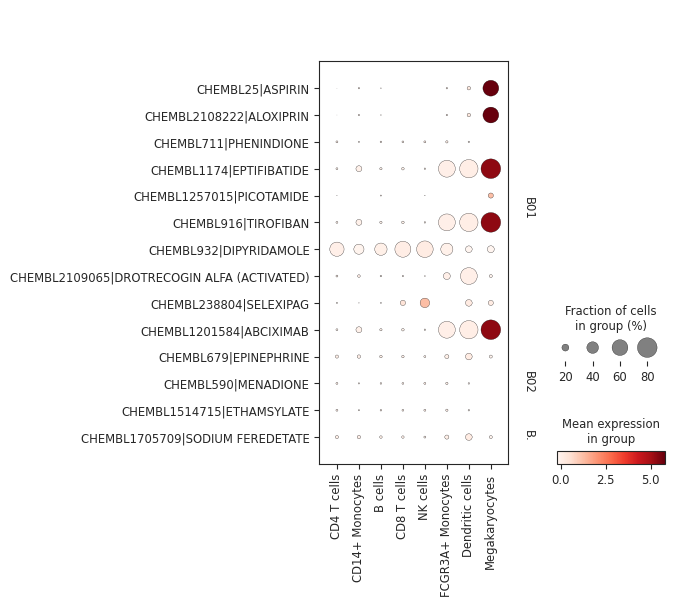

In [10]:
pt_enricher.plot_dotplot(adata, categories=["B01", "B02", "B03"], groupby="louvain")

## Hypergeometric test

We can now apply pertpy's hypergeometric test to test for significance.
By default, it uses the scoring output, but it can also be used with custom `targets` that can be passed.
The output is a dictionary of DataFrames with the clusters used to compute the markers in the original expression space as the keys.

In [11]:
overrepresentation = pt_enricher.hypergeometric(adata)

In [12]:
overrepresentation["B cells"]

,intersection,gene_group,markers,universe,pvals,pvals_adj
CHEMBL1261|CITRIC ACID,0,1,695,1838,1.0,1.0
CHEMBL1021|NEPAFENAC,0,1,695,1838,1.0,1.0
CHEMBL19|METHAZOLAMIDE,0,2,695,1838,1.0,1.0
CHEMBL1200865|LOTEPREDNOL ETABONATE,0,1,695,1838,1.0,1.0
CHEMBL220491|BRINZOLAMIDE,0,1,695,1838,1.0,1.0
...,...,...,...,...,...,...
CHEMBL956|SUPROFEN,0,1,695,1838,1.0,1.0
CHEMBL118|CELECOXIB,0,2,695,1838,1.0,1.0
CHEMBL340978|BENOXAPROFEN,0,1,695,1838,1.0,1.0
CHEMBL1565476|APAZONE,0,2,695,1838,1.0,1.0


Pertpy provides a GSEA (gene set enrichment analysis) wrapper, executed through blitzgsea.
Unlike standard overrepresentation testing, GSEA evaluates gene sets based on their marker scores and assesses the distribution of the gene group members.

In [13]:
enrichment = pt_enricher.gsea(adata)

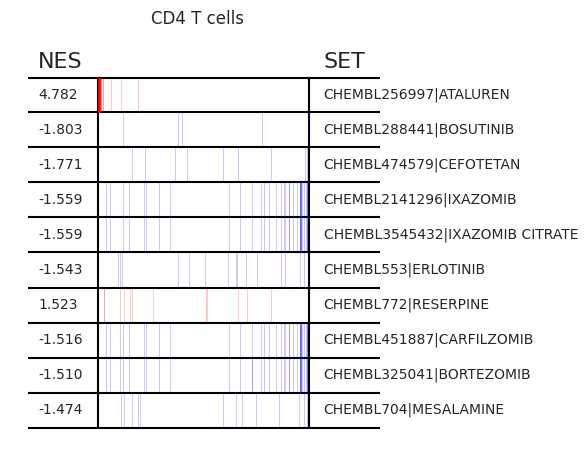

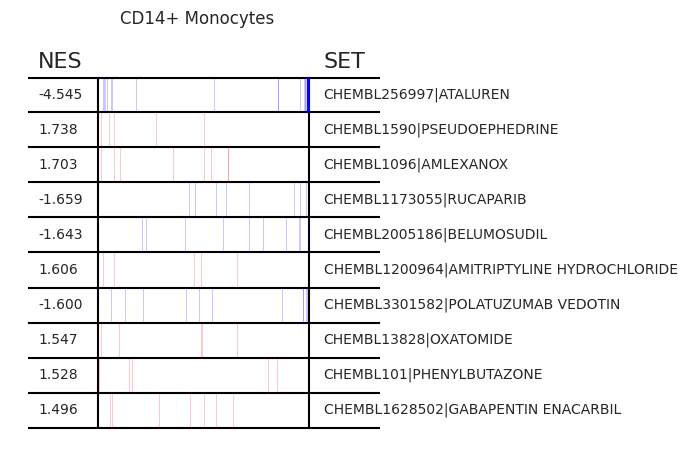

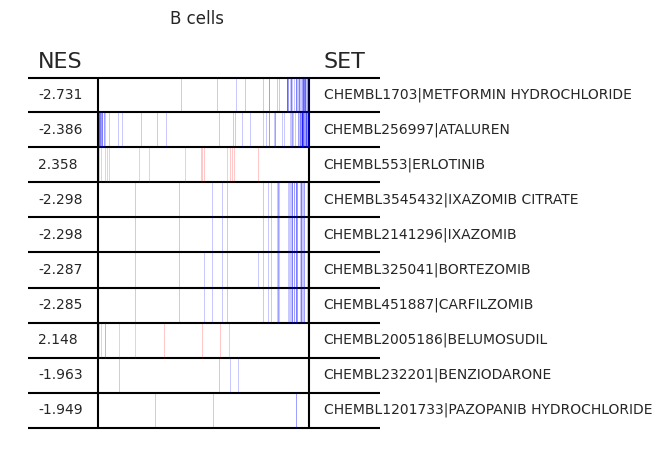

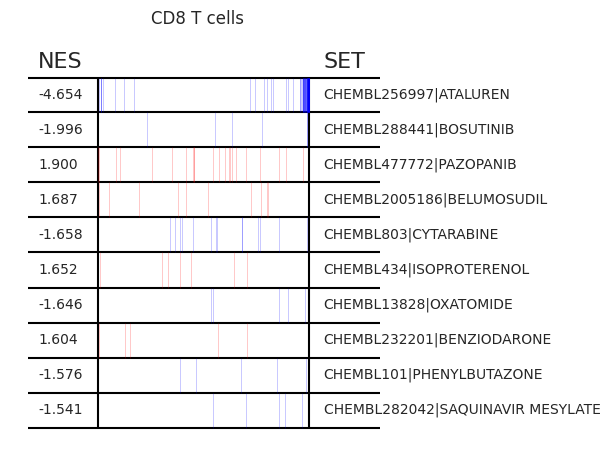

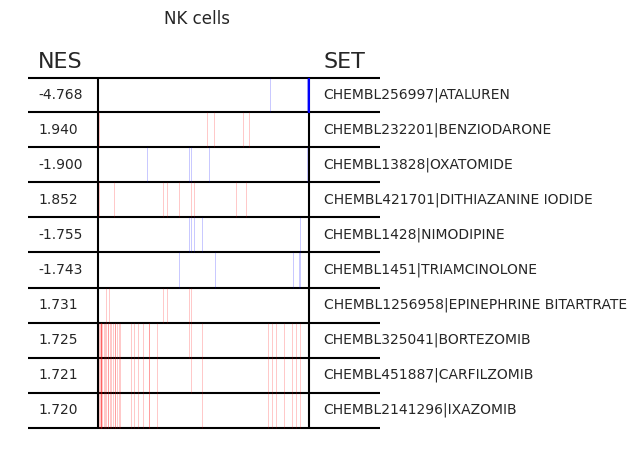

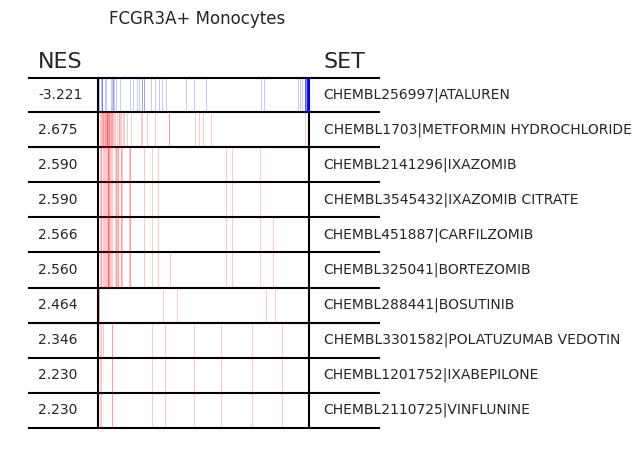

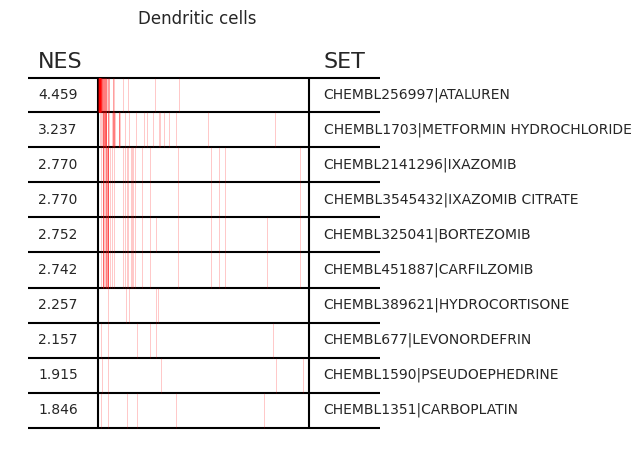

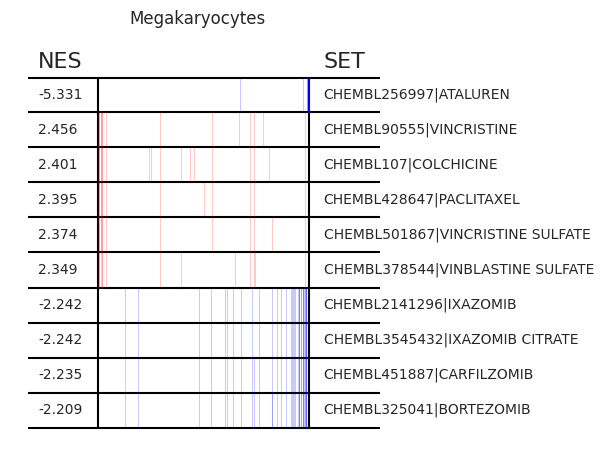

In [14]:
pt_enricher.plot_gsea(adata, enrichment, interactive_plot=True)

## Using custom gene sets

By default, the `score` function uses the chEMBL dataset, but other it is possible to score any gene sets of choice.
The input takes the form of a dictionary with group names as keys and corresponding gene sets as values.

In [15]:
import blitzgsea as blitz

targets = blitz.enrichr.get_library("GO_Molecular_Function_2021")
targets["MHC class II receptor activity (GO:0032395)"]

['HLA-DPA1',
 'HLA-DQB1',
 'HLA-DRA',
 'HLA-DOB',
 'HLA-DRB3',
 'HLA-DQA2',
 'HLA-DOA',
 'HLA-DQA1',
 'HLA-DQB2',
 'HLA-DRB1']

We can pass these gene sets to the `score` function's `targets` parameter:

In [16]:
pt_enricher.score(adata, targets=targets)

In [17]:
enrichment = pt_enricher.gsea(adata, targets=targets)

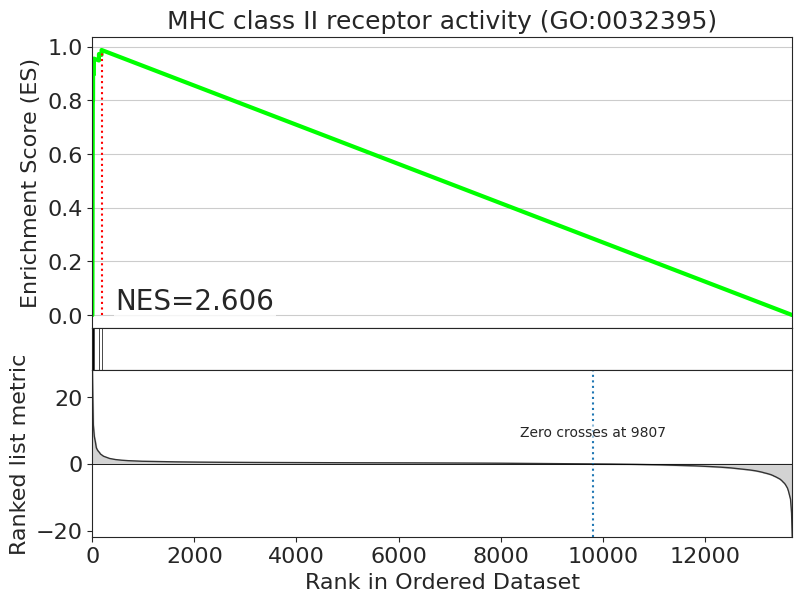

In [18]:
fig = blitz.plot.running_sum(
    signature=adata.uns["pertpy_enrichment_gsea"]["scores"]["B cells"],
    library=adata.uns["pertpy_enrichment_gsea"]["targets"],
    result=enrichment["B cells"],
    geneset="MHC class II receptor activity (GO:0032395)",
    interactive_plot=True,
)
fig.show()

## Conclusion

Pertpy enables gene set enrichment analysis using the metadata in pertpy such as the chEMBL database to identify significant gene sets affected by bioactive molecules in different cell populations.

## References

1. Kanemaru, K., Cranley, J., Muraro, D. et al. Spatially resolved multiomics of human cardiac niches. Nature 619, 801–810 (2023). https://doi.org/10.1038/s41586-023-06311-1